In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import json
import os

from analysis import plot, utils

network_name = 'v1'

### Trial settings

In [2]:
setting_properties = ['duration_window', 'logscale_fr']
settings = {
    'drifting_grating': [
        {'baseline': (.1,  .5), 'drifting_grating': (.5, 3.)}, # seconds
        {'baseline': False, 'drifting_grating': True}
    ],
    'different_grating': [
        {'baseline': (.1,  .5), 'drifting_grating': (.5, 2.)}, # seconds
        {'baseline': False, 'drifting_grating': True}
    ],
    'movie_5s': [
        {'movie': (.1,  3.)},
        {'movie': True}
    ]
}
settings = pd.DataFrame.from_dict(settings, orient='index', columns=setting_properties)
settings

,duration_window,logscale_fr
drifting_grating,"{'baseline': (0.1, 0.5), 'drifting_grating': (...","{'baseline': False, 'drifting_grating': True}"
different_grating,"{'baseline': (0.1, 0.5), 'drifting_grating': (...","{'baseline': False, 'drifting_grating': True}"
movie_5s,"{'movie': (0.1, 3.0)}",{'movie': True}


#### Select trial

In [3]:
# trial_name = 'output_drifting'
# setting_name = 'drifting_grating'

# trial_name = 'output_different_thetas'
# setting_name = 'different_grating'

trial_name = 'output_movie_5s'
setting_name = 'movie_5s'

setting = settings.loc[setting_name]

#### Common parameters

In [4]:
params = dict(
    nbins = 30, # number of firing rate histogram bins
    dt = 2., # ms. spike time histogram bin width
)

### File paths

In [5]:
output_dir = os.path.join('..', 'V1_bio_outputs', trial_name)
data_dir = os.path.join('.', 'data')
trial_dir = os.path.join(data_dir, trial_name)

config_file = os.path.join(output_dir, 'config.json')
spikes_file = os.path.join(output_dir, 'spikes.h5')

if not os.path.isdir(trial_dir):
    os.mkdir(trial_dir)

### Load nodes information

In [6]:
v1_pop_df = pd.read_csv(os.path.join(data_dir, 'v1_population_properties.csv'),
                        index_col='pop_name', dtype={'layer': str})

bio_idx = v1_pop_df['model_type'] == 'biophysical'
bio_pop_names = v1_pop_df.index[bio_idx].tolist()
lif_pop_names = v1_pop_df.index[~bio_idx].tolist()

v1_bio_nodes = pd.read_csv(os.path.join(data_dir, 'v1_biophysical_nodes.csv'), index_col='node_id')
v1_lif_nodes = pd.read_csv(os.path.join(data_dir, 'v1_point_process_nodes.csv'), index_col='node_id')
v1_nodes = pd.concat((v1_bio_nodes, v1_lif_nodes))

### Load spikes

In [7]:
with h5py.File(spikes_file) as f:
    spikes_df = pd.DataFrame({
        'node_ids': f['spikes'][network_name]['node_ids'],
        'timestamps': f['spikes'][network_name]['timestamps']
    })

# choose only biophysical cells
bio_idx = np.array([nid in v1_bio_nodes.index for nid in spikes_df['node_ids']])
spikes_bio_df = spikes_df[bio_idx].copy()
spikes_bio_df.sort_values(by='timestamps', inplace=True, ignore_index=True)
spikes_lif_df = spikes_df[~bio_idx].copy()
spikes_lif_df.sort_values(by='timestamps', inplace=True, ignore_index=True)

# spikes of populations
spikes_bio_df[['pop_name', 'raster_id']] = v1_bio_nodes.loc[spikes_bio_df['node_ids'], ['pop_name', 'raster_id']].values
pop_spike_bio = utils.get_populations(spikes_bio_df, bio_pop_names)
spikes_lif_df[['pop_name', 'raster_id']] = v1_lif_nodes.loc[spikes_lif_df['node_ids'], ['pop_name', 'raster_id']].values
pop_spike_lif = utils.get_populations(spikes_lif_df, lif_pop_names)

### Raster plot

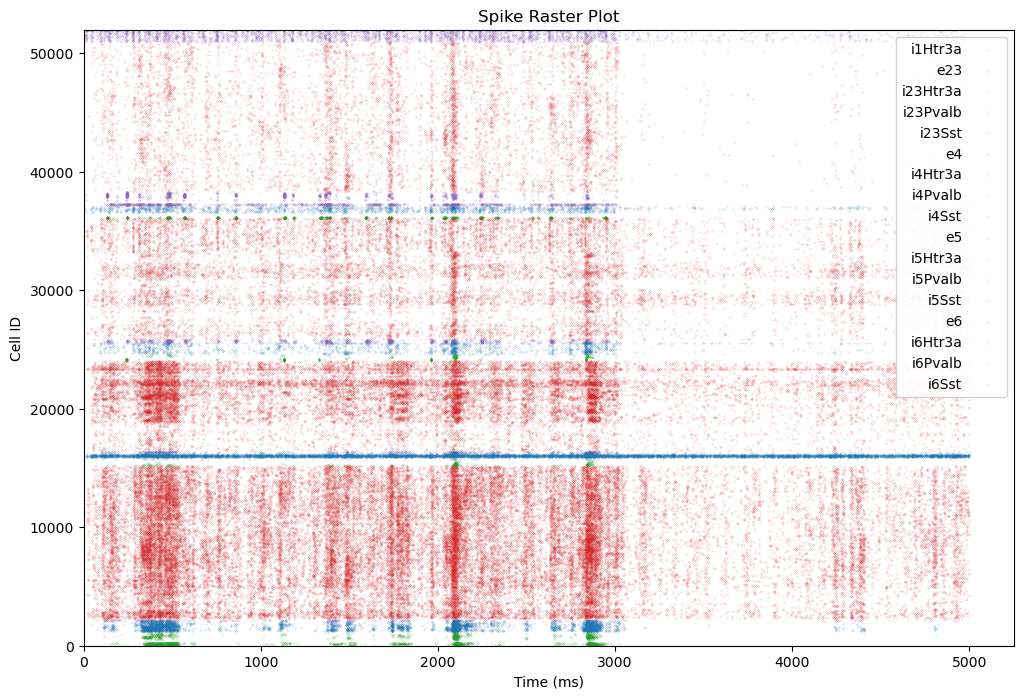

In [8]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))
_ = plot.raster(pop_spike_bio, v1_pop_df['color'].to_dict(), id_column='raster_id', s=0.01, ax=ax)
plt.show()

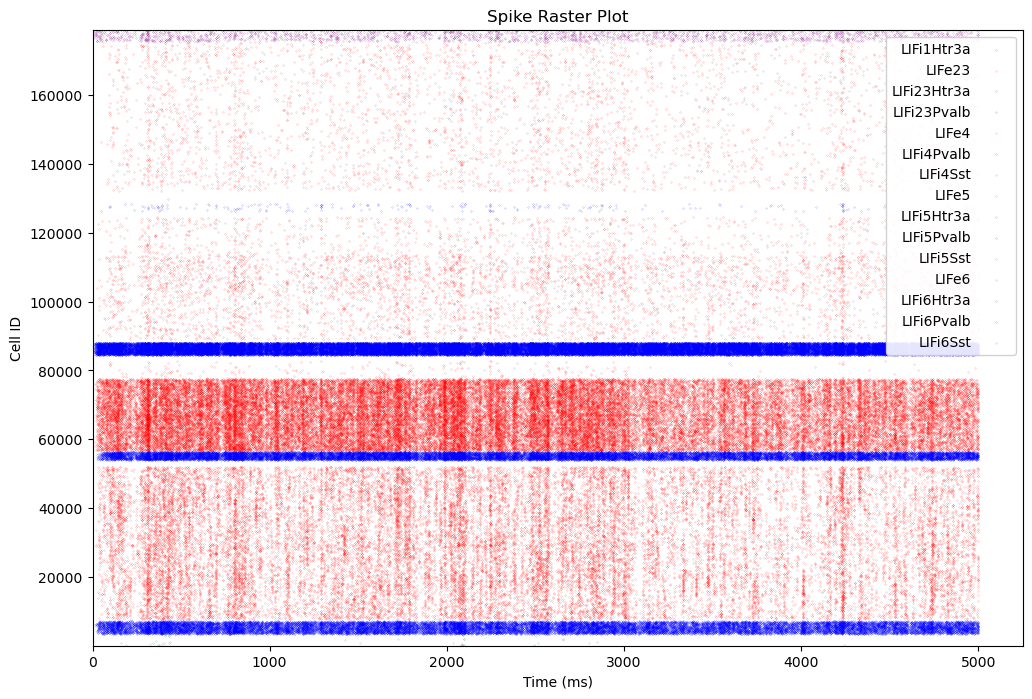

In [9]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))
_ = plot.raster(pop_spike_lif, v1_pop_df['color'].to_dict(), id_column='raster_id', s=0.01, ax=ax)
plt.show()

### Firing rate

In [10]:
v1_pop_ids = utils.get_populations(v1_nodes, v1_pop_df.index, only_id=True)
layers = v1_pop_df['layer'].unique()
model_types = v1_pop_df['model_type'].unique()[::-1]

In [11]:
durations = list(setting.duration_window.keys())
firing_rates = {}
pop_frs = {}
for dur in durations:
    frs = plot.firing_rate(spikes_df, num_cells=len(v1_nodes), time_windows=setting.duration_window[dur])
    firing_rates[dur] = frs
    pop_frs[dur] = {p: frs[nid] for p, nid in v1_pop_ids.items()}

    pop_frs_df = utils.population_statistics(pop_frs[dur])
    print(f'{dur} firing rate (Hz)')
    display(pop_frs_df)

    # save to file
    pop_frs_df.to_csv(os.path.join(trial_dir, dur + '_firing_rate_statisitcs.csv'))

movie firing rate (Hz)


,mean,stdev
pop_name,,
LIFi1Htr3a,0.133257,0.320033
i1Htr3a,1.469400,2.612970
LIFe23,0.021874,0.129245
e23,0.195309,0.414858
LIFi23Htr3a,0.000277,0.009765
i23Htr3a,1.016104,1.690125
LIFi23Pvalb,0.025180,0.109069
i23Pvalb,0.965517,1.334426
LIFi23Sst,0.000000,0.000000


movie


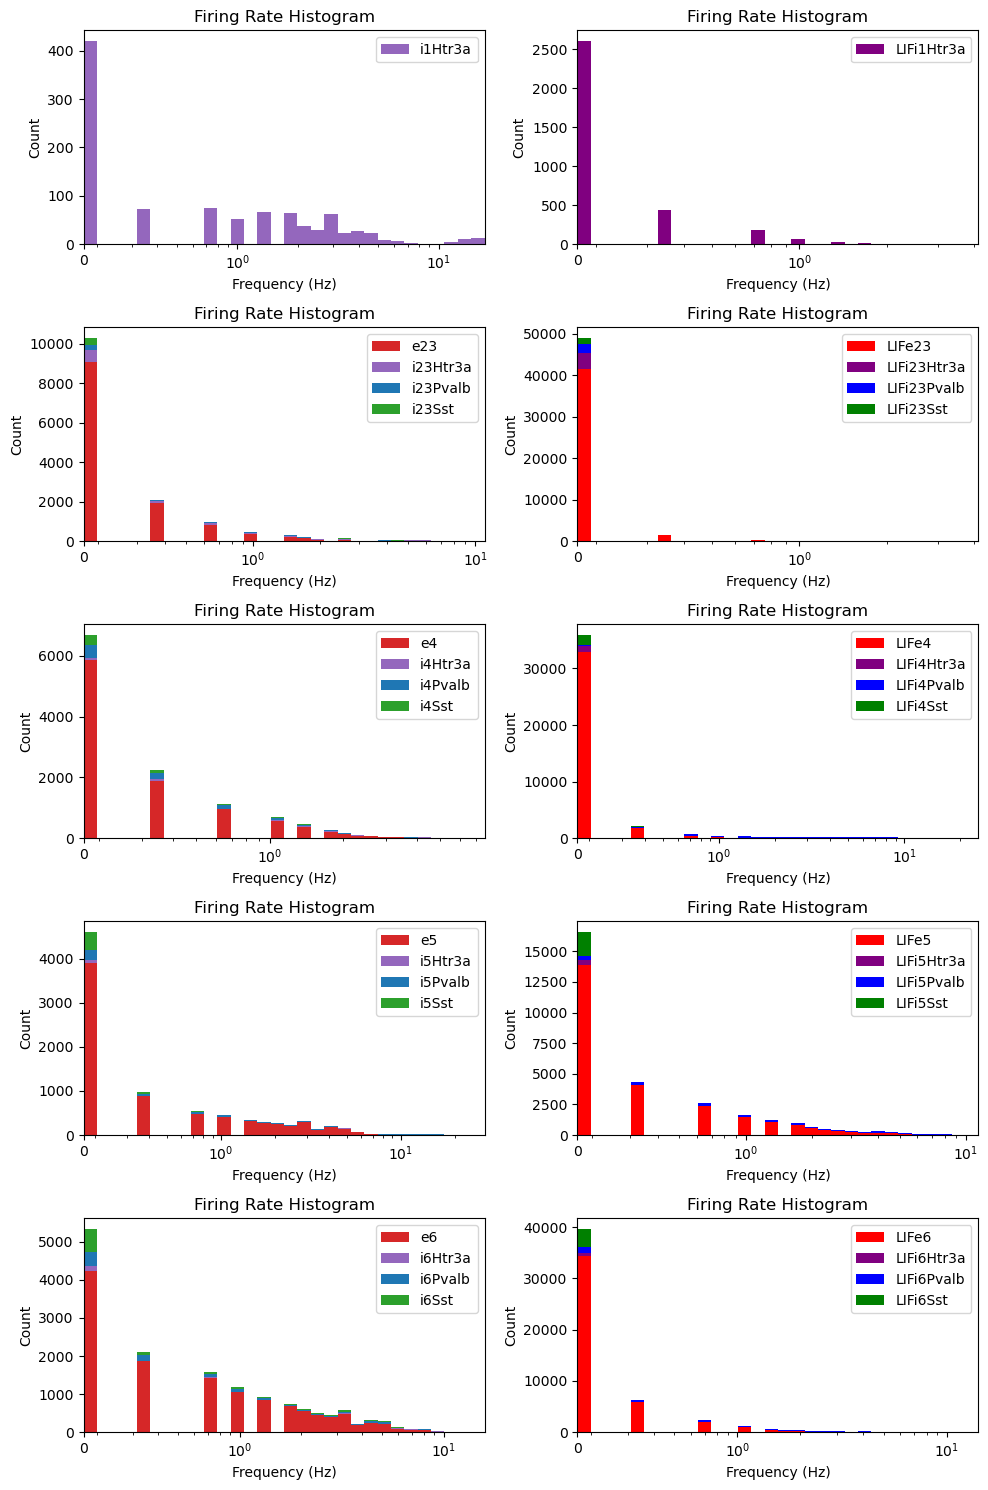

In [12]:
for dur in durations:
    print(dur)
    min_fr = 0.5 / plot.total_duration(setting.duration_window[dur])
    _, axs = plt.subplots(len(layers), 2, figsize=(10, 3 * len(layers)))
    for j, M in enumerate(model_types):
        for i, L in enumerate(layers):
            ax = axs[i, j]
            pops = v1_pop_df.index[(v1_pop_df['layer'] == L) & (v1_pop_df['model_type'] == M)]
            pop_fr = {p: pop_frs[dur][p] for p in pops}
            plot.firing_rate_histogram(pop_fr, v1_pop_df.loc[pops, 'color'], bins=params['nbins'],
                                       min_fr=min_fr, logscale=setting.logscale_fr[dur], stacked=True, ax=ax)
    plt.tight_layout()
    plt.show()

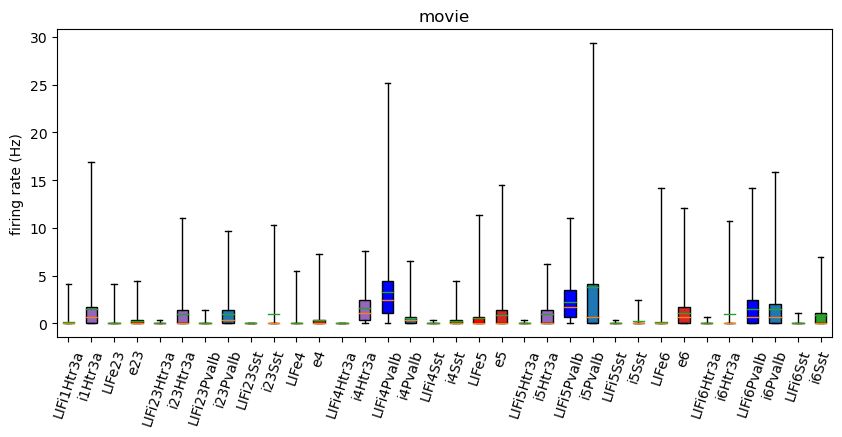

In [13]:
for dur in durations:
    plt.figure(figsize=(10, 4))
    pop_names = pop_frs[dur].keys()
    bplot = plt.boxplot(pop_frs[dur].values(), labels=pop_names, whis=(0., 100.),
                        showmeans=True, meanline=True, showfliers=False, showcaps=True,
                        widths=0.5, patch_artist=True,  # fill with color
                        meanprops={'linestyle': '-'})
    for patch, color in zip(bplot['boxes'], v1_pop_df.loc[pop_names, 'color']):
        patch.set_facecolor(color)
    plt.ylabel('firing rate (Hz)')
    plt.xticks(rotation=72, ha='center')
    plt.title(dur)
plt.show()

### Population spike rate time histogram

In [14]:
with open(config_file, 'r') as f:
    t_stop = json.load(f)['run']['tstop']

time = np.array([0, t_stop, params['dt']]) # ms
pop_rspk = {p: plot.pop_spike_rate(spk['timestamps'], time) for p, spk in (pop_spike_bio | pop_spike_lif).items()}

In [15]:
spike_rate_file = os.path.join(trial_dir, 'spike_rate.h5')
with h5py.File(spike_rate_file, 'w') as f:
    f.create_dataset('time', data=time)
    grp = f.create_group('populations')
    for p, rspk in pop_rspk.items():
        pop = grp.create_group(p)
        pop.create_dataset('data', data=rspk)
        pop.attrs['number'] = len(v1_pop_ids[p])